In [9]:
%matplotlib inline

# Imports
import networkx as nx
import numpy
import matplotlib.pyplot as plt
import pandas

try:
    import seaborn; seaborn.set()
    
except ImportError:
    pass

# Import widget methods
from ipywidgets.widgets import *

# Graph Construction

We'll manually create a deterministic graph.

In [2]:
g = nx.Graph()
print((g.number_of_nodes(), g.number_of_edges()))

(0, 0)


In [3]:
g.add_node('alice')
print((g.number_of_nodes(), g.number_of_edges()))
g.add_node('bob')
print((g.number_of_nodes(), g.number_of_edges()))

(1, 0)
(2, 0)


In [4]:
# Add an edge between alice and bob
g.add_edge('alice', 'bob')

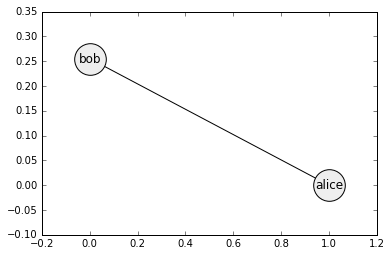

In [5]:
g_layout = nx.spring_layout(g, iterations=1000)
nx.draw_networkx(g, pos=g_layout, node_color='#eeeeee', node_size=1000)

# Random Graph Construction

Next, we'll grow our own graph using the following procedure:

1. Each time step, sample a number of nodes to add.
2. For each node to add, sample a random set of edges to add.

**This formulation is a bit ambiguous.** For instance, regarding (2), what is the pool of potential edges from which we might draw? Is this pool updated each time step? This introduces questions of **time discretization** and **synchronicity.**

We seem to be implying that within each time step ($\Delta t$) we are only considering the nodes that currently exist (existed or were created at the end of the last time step).

In [6]:
# Create a new graph
g = nx.Graph()
num_steps = 10

# Iterate through time
for t in range(num_steps):
    # Draw a random number of nodes to add
    num_nodes_add = numpy.random.binomial(10, 0.1)
    num_edges_add = 0
        
    # Iterate through nodes to add; counting from last node ID
    for new_node_number in range(g.number_of_nodes(), g.number_of_nodes() + num_nodes_add):
        
        # Sample number of edges
        num_edges_per_node = numpy.random.binomial(g.number_of_nodes(), 0.3)
        num_edges_add += num_edges_per_node
                
        # New edges are determined randomly based on previously extant nodes
        nodes_to_connect = numpy.random.choice(list(range(g.number_of_nodes() + 1)), num_edges_per_node)

        nodes_to_connect = [n for n in nodes_to_connect if n != new_node_number]
        nodes_to_connect = [n for n in nodes_to_connect if len(g.neighbors(n)) < 3]
        
        # Create edges to previously extant nodes
        g.add_edges_from([(new_node_number, x) for x in nodes_to_connect])
        
        g.add_node(new_node_number)
        
        print((g.number_of_nodes(), g.number_of_edges()))
        
# If any of the nodes are unconnected...
if 0 in map(len, [g.neighbors(n) for n in g.nodes()]):
    unconnected_nodes = [n for n in g.nodes() if len(g.neighbors(n)) == 0]
    
    for unconnected_node in unconnected_nodes:
        new_connection_num = numpy.random.choice([
                n for n in list(range(g.number_of_nodes())) if n not in unconnected_nodes
            ], 1)

        g.add_edges_from([(unconnected_node, x) for x in new_connection_num])
        

(1, 0)
(2, 0)
(3, 0)
(4, 0)
(5, 1)
(6, 3)
(7, 5)
(8, 7)
(9, 10)
(10, 11)
(11, 11)
(12, 12)


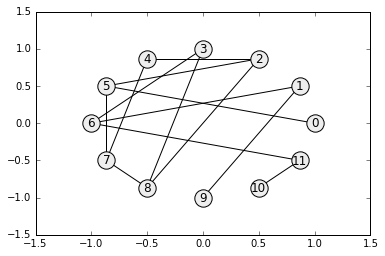

In [7]:
g_layout = nx.circular_layout(g)
nx.draw_networkx(g, pos=g_layout, node_color='#eeeeee')

## Better Random Graph

Features I would like in my random graph algorithm:

1. Guarantee that every node has at least one connection.
2. Guarantee that the graph is connected (a path exists between any pair of nodes).
3. Limit the number of connections any given node can have (pruning).

There are some limitations in this approach. The check for connections fewer than the specified number occurs (3) after the check on connections to the root node (2) so it is possible that a key link (to the root node) could be pruned. This is made significantly less likely by doing a final check on the graph for any unconnected nodes. **Rules 1 and 2 may seem redundant, but if only rule 1 is implemented than there could be two or more separate graphs.**

This results in at least one interesting property. If the number of nodes, $N$, is high enough, the root node (0) has a number of edges, $e_0$, that is equal to the maximum allowed number of edges, $e_{max}$:

$$
N \ge e_{max}: e_0 = e_{max}
$$

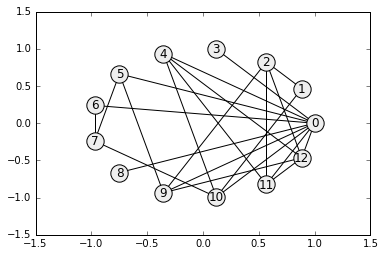

In [57]:
def draw_random_graph(num_steps, max_num_connections):
    # Create a new graph
    g = nx.Graph()
    
    # Iterate through time
    for t in range(num_steps):
        # Draw a random number of nodes to add
        num_nodes_add = numpy.random.binomial(10, 0.1)
        num_edges_add = 0

        # Initially, the only node connected to the root is itself
        nodes_connected_to_root = [0]

        # Iterate through nodes to add; counting from last node ID
        for new_node_number in range(g.number_of_nodes(), g.number_of_nodes() + num_nodes_add):

            # Sample number of edges
            num_edges_per_node = numpy.random.binomial(g.number_of_nodes(), 0.3)
            num_edges_add += num_edges_per_node

            # New edges are determined randomly based on previously extant nodes
            nodes_to_connect = numpy.random.choice(list(range(g.number_of_nodes() + 1)), num_edges_per_node)

            # Filter out the number of the newest node (cannot connect to self)
            nodes_to_connect = [n for n in nodes_to_connect if n != new_node_number]

            # If no new connection is connected to the root node (1), then
            #  randomly connect to a root-connected node
            if g.number_of_nodes() > 1:
                if len(set(nodes_to_connect).intersection(nodes_connected_to_root)) == 0:
                    nodes_to_connect.extend(numpy.random.choice(list(nodes_connected_to_root), 1))

            # Filter out those nodes that have more than the upper limit of connections
            nodes_to_connect = [n for n in nodes_to_connect if len(g.neighbors(n)) < max_num_connections]

            # Create edges to previously extant nodes
            g.add_edges_from([(new_node_number, x) for x in nodes_to_connect])

            # Add this node; note that it is connected to the root
            g.add_node(new_node_number)
            nodes_connected_to_root.append(new_node_number)

            #print((g.number_of_nodes(), g.number_of_edges()))

    # If any of the nodes remain unconnected...
    if 0 in map(len, [g.neighbors(n) for n in g.nodes()]):
        unconnected_nodes = [n for n in g.nodes() if len(g.neighbors(n)) == 0]

        if g.number_of_edges() > 0:
            for unconnected_node in unconnected_nodes:
                new_connection_num = numpy.random.choice([
                        n for n in list(range(g.number_of_nodes())) if n not in unconnected_nodes
                    ], 1)

                g.add_edges_from([(unconnected_node, x) for x in new_connection_num])

    g_layout = nx.circular_layout(g)
    nx.draw_networkx(g, pos=g_layout, node_color='#eeeeee')
    
interact(draw_random_graph,
         num_steps=IntSlider(min=5, max=100, value=10),
         max_num_connections=IntSlider(min=2, max=10, value=3))